# Word2vec and Glove

 In this notebook I use already pre-trained word-embedding models like Word2vec and Glove. These models were trained on huge datasets to get semantic meaning of each word. Word2vec relies on backpropagation, while Glove on matrix factorization. Both models can capture meaning of words pretty well compared to bag of words or tf-idf.

 I try these methods:
 1. Building article embeddings based on averaging word2vec embeddings (based on already pretrained word2vec and also training on our dataset)
 2. Building article embeddings based on averaging glove embeddings
 3. Building article embeddings based on combination of word2vec and tfidf 

In [7]:
# data preprocessing, visualization
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# models
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from sklearn.ensemble import RandomForestClassifier
from gensim.models import Word2Vec
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

In [13]:
# df_merged = pd.read_csv("../data/merged_all_datasets.csv")
df_merged = pd.read_csv("../data/merged_datasetes_balanced.csv")
# df_merged = pd.read_csv("../data/merged_datasetes_balanced_huge.csv")

In [14]:
x_train, x_test, y_train, y_test = train_test_split(
    df_merged["title"], 
    df_merged["clickbait"],
    test_size=0.2, 
    random_state=42
)

# Word2Vec

In [10]:
# Thomas Mikolov tried to find the meaning of words and how to represent them numerically
# He came up with an idea to train neural network so that words that appear in similar contexts have close vectors
# Word vectors provide semantic meaning of words as vectors based on training corpus
# This algorithm was a great invention that allows to capture analogies 
# (e.g.  king - man + woman = queen or woman + europe + physics + scientist = Marie Curie

# source: Natural Language Processing in Action (book)

In [11]:
# I train Word2Vec on my own data, but the thing is that the articles are general and our corpus is not so huge
# We could use all merged datasets instead of balanced, but still the domain of my data is general
# Hence it would be better idea to just get pre-trained models and get embeddings from it.

In [12]:
# Each article is splitted into tokens (words)
sentences = [sentence.split() for sentence in x_train]
w2v_model = Word2Vec(sentences, window=5, min_count=5, workers=4)

In [13]:
w2v_model.wv

### Exploring the model

In [17]:
w2v_model.wv.most_similar(positive="warning")

[('going', 0.9836194515228271),
 ('out', 0.983172595500946),
 ('its', 0.9830321669578552),
 ('face', 0.9828433990478516),
 ('her', 0.9827855825424194),
 ('president', 0.9827393889427185),
 ('found', 0.9827317595481873),
 ('back', 0.9827278852462769),
 ('video', 0.9827114343643188),
 ('police', 0.9826991558074951)]

In [18]:
w2v_model.wv.most_similar(positive="warns")

[('court', 0.9992703199386597),
 ('top', 0.9991949796676636),
 ('say', 0.9991567134857178),
 ('military', 0.9991048574447632),
 ('South', 0.9990924596786499),
 ('probe', 0.9990585446357727),
 ('would', 0.999024510383606),
 ('U.N.', 0.9990128874778748),
 ('foreign', 0.9990090131759644),
 ('law', 0.9989861845970154)]

In [19]:
w2v_model.wv.most_similar(positive=["car", "vehicle"], topn=5)

[('Iraq', 0.9986475110054016),
 ('opposition', 0.9985900521278381),
 ('show', 0.9985446333885193),
 ('oil', 0.998509407043457),
 ('case', 0.9984796047210693)]

In [14]:
def create_text_vectors_from_word_embedding_word2vec_model(
    model: gensim.models.keyedvectors.KeyedVectors,
    sentence: str,
    dimension_embeddings: int,
):
    '''
    Function that generates text embedding vector by taking an average of all word embedding vectors. 
    If no words appear in word2vec then algorithm outputs vector of zeros.
    '''
    
    # Split words into on array of words
    words_splitted = sentence.split()
    # For each word in text get its vector representation
    words_vecs = [model[word] for word in words_splitted if word in model]
    # If none of this words appear in our word2vec model then its length will be zero and we just create array of zeros
    if len(words_vecs) == 0:
        return np.zeros(dimension_embeddings)
        
    # otherwise, we just calculate the mean of all these vector representations 
    words_vectors_word2vec = np.array(words_vecs)
    return words_vectors_word2vec.mean(axis=0)

# For each article we get mean vector embedding
x_train_vect = np.array([create_text_vectors_from_word_embedding_word2vec_model(w2v_model.wv, sentence, 100) for sentence in x_train])
x_test_vect = np.array([create_text_vectors_from_word_embedding_word2vec_model(w2v_model.wv, sentence, 100) for sentence in x_test])

## Training models

In [29]:
RF = RandomForestClassifier(random_state = 0)
RF.fit(x_train_vect, y_train)

RandomForestClassifier(random_state=0)

In [30]:
pred_rf = RF.predict(x_test_vect)

In [31]:
RF.score(x_test_vect, y_test)

0.8545

In [32]:
print(classification_report(y_test, pred_rf))

              precision    recall  f1-score   support

           0       0.84      0.87      0.86      2019
           1       0.86      0.84      0.85      1981

    accuracy                           0.85      4000
   macro avg       0.85      0.85      0.85      4000
weighted avg       0.85      0.85      0.85      4000



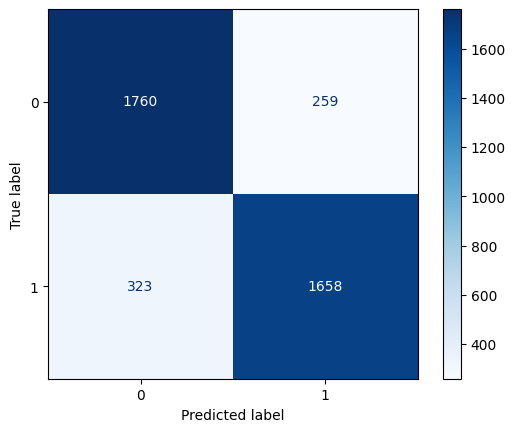

In [33]:
cm = confusion_matrix(y_test, pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [35]:
xgb_model = xgb.XGBClassifier(random_state = 0)
xgb_model.fit(x_train_vect, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

In [36]:
pred_xgb = xgb_model.predict(x_test_vect)

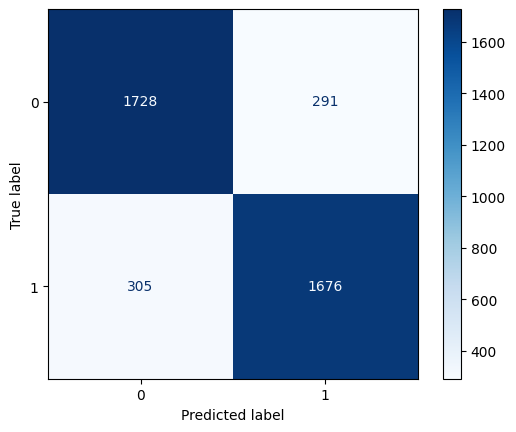

In [37]:
cm = confusion_matrix(y_test, pred_xgb)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Using pre-trained word2vec model

In [4]:
import gensim.downloader as api
# Loading already pre-trained model on google news
wv = api.load('word2vec-google-news-300')

In [5]:
wv

In [7]:
ans_vect =  wv['woman'] + wv['Europe'] + wv['physics'] + wv['scientist'] - wv['male'] - 2 * wv['man']
wv.similar_by_vector(ans_vect, topn= 15)

[('physics', 0.6271687150001526),
 ('scientist', 0.6203182339668274),
 ('physicist', 0.5793354511260986),
 ('science', 0.5157865285873413),
 ('geochemist', 0.5141739845275879),
 ('researcher', 0.5038483738899231),
 ('Physicist', 0.5035572648048401),
 ('planetary_scientist', 0.4968586564064026),
 ('Chu_Nobel_laureate', 0.48720353841781616),
 ('geophysicist', 0.48685815930366516),
 ('particle_physicist', 0.4841868281364441),
 ('Physics', 0.4776281416416168),
 ('astrophysics', 0.4745880365371704),
 ('theoretical_astrophysics', 0.4680024981498718),
 ('Scripps_Oceanography', 0.466260701417923)]

In [8]:
wv.most_similar(positive= ["Cristiano_Ronaldo", "science"],negative=["sport"], topn=5)

[('Fernando_Torres', 0.5034375786781311),
 ('Dimitar_Berbatov', 0.4991177022457123),
 ('Ronaldo', 0.49781620502471924),
 ('striker_Fernando_Torres', 0.4968187212944031),
 ('Carlos_Tevez', 0.473631888628006)]

In [27]:
wv.most_similar(positive = ["woman", "sword"], negative = ["man"])

[('swords', 0.6237959861755371),
 ('broadsword', 0.5374425649642944),
 ('scimitar', 0.4882256090641022),
 ('katana', 0.4881975054740906),
 ('knife', 0.48329806327819824),
 ('samurai_sword', 0.4832817614078522),
 ('sandal_flick', 0.47444045543670654),
 ('broadswords', 0.4732465445995331),
 ('crucifix', 0.46822476387023926),
 ('Samurai_sword', 0.4644865095615387)]

In [20]:
wv.most_similar(positive= ["king", "woman"],negative=["man"], topn=2)

[('queen', 0.7118193507194519), ('monarch', 0.6189674139022827)]

In [19]:
wv.similar_by_vector(wv["king"] + wv["woman"] - wv["man"], topn=2)

[('king', 0.8449392318725586), ('queen', 0.7300517559051514)]

In [6]:
x_train_vect_pretrained = np.array([create_text_vectors_from_word_embedding_word2vec_model(wv, sentence, 300) for sentence in x_train])
x_test_vect_pretrained= np.array([create_text_vectors_from_word_embedding_word2vec_model(wv, sentence, 300) for sentence in x_test])

NameError: name 'create_text_vectors_from_word_embedding_word2vec_model' is not defined

In [43]:
RF = RandomForestClassifier(random_state = 0)
RF.fit(x_train_vect_pretrained, y_train)

RandomForestClassifier(random_state=0)

In [44]:
pred_rf = RF.predict(x_test_vect_pretrained)

In [45]:
RF.score(x_test_vect_pretrained, y_test)

0.8675

In [46]:
print(classification_report(y_test, pred_rf))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      2019
           1       0.87      0.87      0.87      1981

    accuracy                           0.87      4000
   macro avg       0.87      0.87      0.87      4000
weighted avg       0.87      0.87      0.87      4000



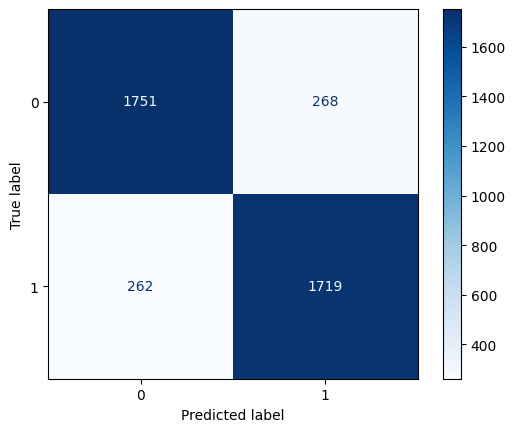

In [47]:
cm = confusion_matrix(y_test, pred_rf)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
# The question that appears in my head is that Word2vec is already pretrained, so why we should train it once again?
# The answer is that you can use pre-trained model without fitting it to your data if it is general domain
# Link:
# https://datascience.stackexchange.com/questions/110006/why-we-need-to-train-word2vec-when-word2vec-itself-is-said-to-be-pretrained
# https://datascience.stackexchange.com/questions/92856/the-reason-behind-using-a-pre-trained-model
# https://www.google.com/search?q=usng+pretrained+word2vec+or+not&oq=usng+pretrained+word2vec+or+not&gs_lcrp=EgZjaHJvbWUyBggAEEUYOTIJCAEQIRgKGKABMgkIAhAhGAoYoAHSAQgzOTY5ajBqNKgCALACAQ&sourceid=chrome&ie=UTF-8

In [ ]:
#Find out what articles were wrongly classified

In [18]:
x_test

47044    A Full Breakdown Of The Long Feud Involving Am...
44295    Kellyanne Conway Just Humiliated Herself On Na...
74783    40,000 MA Drug Cases Could Be Thrown Out Becau...
70975    ROFL: An Adult Film Company Just Offered To Ma...
46645    Santilli Freed Under Plea Pact as Vegas Shooti...
                               ...                        
67666             13 Tech Resolutions Everyone Should Make
51146    If The Bond Girl Age Gaps In "James Bond" Were...
42494    WATCH: Paul Ryan Basically Admits Republicans ...
52517    What zapping your brain with electricity feels...
7754     Con artist raked in $1M returning designer bag...
Name: title, Length: 16000, dtype: object

In [19]:
results_test_df = pd.DataFrame(x_test)
results_test_df["y_true"] = y_test
results_test_df["y_pred"] = pred_rf

In [20]:
results_test_df

,title,y_true,y_pred
47044,A Full Breakdown Of The Long Feud Involving Am...,1,1
44295,Kellyanne Conway Just Humiliated Herself On Na...,1,1
74783,"40,000 MA Drug Cases Could Be Thrown Out Becau...",1,1
70975,ROFL: An Adult Film Company Just Offered To Ma...,1,1
46645,Santilli Freed Under Plea Pact as Vegas Shooti...,1,0
...,...,...,...
67666,13 Tech Resolutions Everyone Should Make,1,1
51146,"If The Bond Girl Age Gaps In ""James Bond"" Were...",1,1
42494,WATCH: Paul Ryan Basically Admits Republicans ...,1,1
52517,What zapping your brain with electricity feels...,1,1


In [21]:
wrongly_classified = results_test_df[results_test_df["y_true"] != results_test_df["y_pred"]]

In [22]:
wrongly_classified

,title,y_true,y_pred
46645,Santilli Freed Under Plea Pact as Vegas Shooti...,1,0
65509,Western Sahara: Kitesurfing in the Dakhla dang...,1,0
36981,Trump Tells News Anchors At Private Lunch That...,0,1
62181,It Begins: Supreme Court Rejects Racially Gerr...,1,0
9724,The week’s best podcasts: You Must Remember Th...,0,1
...,...,...,...
13464,Mayor Aims to Add Spark to Flagging Sex Lives,0,1
77669,News From Elsewhere,1,0
1944,12 Countries With The Most Unfilled Jobs,0,1
27308,The Perils of Empathy,0,1


In [ ]:
i=0
for index, row in wrongly_classified.iterrows():
    print(row["title"])
    print("True Label:", row['y_true'])
    print("Predicted Label:", row['y_pred'])
    print("-" * 40)
    i+=1
    if i == 20:
        break

# Word2vec + weighted tfidf

In [ ]:
# Source:
# https://freedium.cfd/https://medium.com/@chandu.bathula16/machine-learning-concept-9-71b6bd2ea77d
# https://medium.com/analytics-vidhya/featurization-of-text-data-bow-tf-idf-avgw2v-tfidf-weighted-w2v-7a6c62e8b097

In [70]:
def compute_weighted_word2vec_tf_idf(
    documents: pd.core.series.Series, 
    word2vec_model: gensim.models.keyedvectors.KeyedVectors, 
    tfidf_vectorizer: TfidfVectorizer
):
    '''
    Function that combines tf-idf and word2vec. 
    Instead of just taking an average of word-embeddings from glove or word2vec for each word we multiply its tf-idf value with word2vec embedding 
    and then normalize its value
    '''
    # Let us calculate tf-idf scores
    tfidf_matrix = tfidf_vectorizer.transform(documents)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
    tfidf_scores = tfidf_matrix.toarray()
    
    document_vectors = []

    for i, document in enumerate(documents):
        words = document.split() # Split into sentences
        tfidf_vector = tfidf_scores[i]
        
        doc_vector = np.zeros(word2vec_model.vector_size)  # Zero vector
        
        weight_sum = 0  # sum of tf-idf weights for normalization
        
        for word in words:
            if word in word2vec_model and word in tfidf_feature_names:
                word_vector = word2vec_model[word]
                word_index = np.where(tfidf_feature_names == word)[0][0]
                tfidf_weight = tfidf_vector[word_index]
                
                # Add the weighted word vector to the document vector
                doc_vector += word_vector * tfidf_weight
                weight_sum += tfidf_weight
        
        if weight_sum != 0:
            doc_vector /= weight_sum  # Then we apply normalization by sum of weight of tf-idf vectors
        
        document_vectors.append(doc_vector)
    
    return np.array(document_vectors)



# Compute TF-IDF on the training data
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(x_train)

# Transform the training and test data using the weighted Word2Vec algorithm
x_train_vectors = compute_weighted_word2vec_tf_idf(x_train, wv, tfidf_vectorizer)
x_test_vectors = compute_weighted_word2vec_tf_idf(x_test, wv, tfidf_vectorizer)

In [62]:
type(tfidf_vectorizer)

sklearn.feature_extraction.text.TfidfVectorizer

0.839
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      2019
           1       0.82      0.86      0.84      1981

    accuracy                           0.84      4000
   macro avg       0.84      0.84      0.84      4000
weighted avg       0.84      0.84      0.84      4000



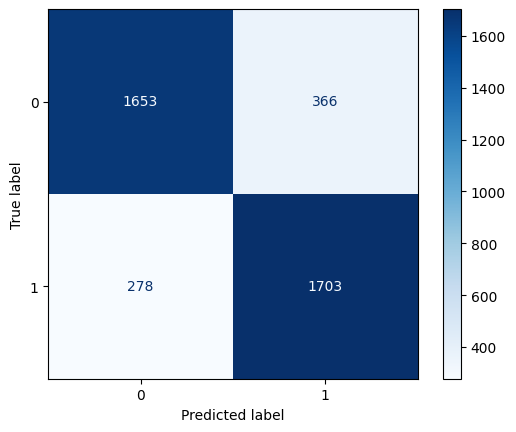

In [59]:
RF = RandomForestClassifier(random_state = 0)
RF.fit(x_train_vectors, y_train)

pred_rf = RF.predict(x_test_vectors)
print(RF.score(x_test_vectors, y_test))
print(classification_report(y_test, pred_rf))

cm = confusion_matrix(y_test, pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Glove

In [50]:
embeddings_glove = {}
# This is reference to local path
# Glove models are huge, so we decided not to store it in github, but on google drive
path_local = r"C:\Users\Mateusz\Desktop\PRACA INZYNIERSKA\glove.6B.100d.txt"
with open(path_local, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_glove[word] = coefs

In [55]:
embeddings_glove['trump']

array([-0.15731 , -0.75503 ,  0.36845 , -0.18958 , -0.16896 , -0.23157 ,
       -0.22658 , -0.30186 ,  0.24372 ,  0.61896 ,  0.58995 ,  0.047638,
       -0.055164, -0.70211 ,  0.22084 , -0.69232 ,  0.49419 ,  1.4285  ,
       -0.25362 ,  0.20031 , -0.26192 ,  0.05315 , -0.048418, -0.44982 ,
        0.54644 , -0.014645, -0.015531, -0.61197 , -0.91964 , -0.7528  ,
        0.64843 ,  1.0934  ,  0.052682,  0.33345 ,  0.10532 ,  0.59517 ,
        0.023104, -0.37105 ,  0.29749 , -0.23683 ,  0.079566, -0.10326 ,
        0.35885 , -0.28935 , -0.19881 ,  0.22908 , -0.061435,  0.56127 ,
       -0.017115, -0.32868 , -0.78417 , -0.49375 ,  0.34944 ,  0.16278 ,
       -0.061168, -1.3106  ,  0.39152 ,  0.124   , -0.20873 , -0.18473 ,
       -0.56184 ,  0.55693 ,  0.012114, -0.54545 , -0.31409 ,  0.1     ,
        0.31543 ,  0.74757 , -0.47734 , -0.18332 , -0.65623 ,  0.40768 ,
       -0.30697 , -0.47247 , -0.7421  , -0.44978 , -0.078122, -0.52673 ,
       -0.70633 ,  1.3271  ,  0.26298 , -0.91    , 

In [61]:
def get_glove_text_embedding(
    sentence: str, 
    glove_model: dict,
):
    '''
    Function generating text_embedding from word-embedding glove model. 
    Function similar to the one above for word2vec
    '''
    words = sentence.split()  
    word_vectors_glove = []

    for word in words:
        if word in glove_model: 
            word_vectors_glove.append(glove_model[word])

    if not word_vectors_glove:
        return np.zeros(len(next(iter(glove_model.values()))))
        
    return np.mean(word_vectors_glove, axis=0)

In [62]:
x_train

5894     Party set to sack Mugabe, Zimbabweans celebrat...
3728     Aleppo risks becoming 'one giant graveyard', U...
8958     TeleSUR promotional campaign causes controvers...
7671         Scientists improve cancer research techniques
5999     You'll Be 'Thunderstruck' By This AC/DC-Themed...
                               ...                        
11284    SUSAN RICE REFUSES To Testify Before The Senat...
11964    NO JOKE! THE EPA STICKS ITS NOSE INTO THE NAIL...
5390                                  Bloomberg Technology
860      Bride's dance performance at her wedding is br...
15795    MCCAIN NEEDS TO GO! Makes Claim That Trump Is ...
Name: title, Length: 16000, dtype: object

In [63]:
x_train_vect_glove = np.array([get_glove_text_embedding(sentence, embeddings_glove) for sentence in x_train])
x_test_vect_glove = np.array([get_glove_text_embedding(sentence, embeddings_glove) for sentence in x_test])

In [65]:
RF = RandomForestClassifier(random_state = 0)
RF.fit(x_train_vect_glove, y_train)

pred_rf = RF.predict(x_test_vect_glove)
print(RF.score(x_test_vect_glove, y_test))
print(classification_report(y_test, pred_rf))

cm = confusion_matrix(y_test, pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

0.85225


In [23]:
corpus = [
    "Hello my name is Trump",
    "Trump is really great person",
    "Did you hear me?"
]
corpus_series = pd.Series(corpus)

In [24]:
corpus_series

0          Hello my name is Trump
1    Trump is really great person
2                Did you hear me?
dtype: object

In [25]:
tfidf_vectorizer = TfidfVectorizer()
x_train_tfidf_vectorizer.fit_transform(corpus_series)

TfidfVectorizer()

In [ ]:
# def compute_weighted_word2vec_tf_idf(
#     documents: pd.core.series.Series, 
#     word2vec_model: gensim.models.keyedvectors.KeyedVectors, 
#     tfidf_vectorizer: TfidfVectorizer
# ):
#     '''
#     Function that combines tf-idf and word2vec. 
#     Instead of just taking an average of word-embeddings from glove or word2vec for each word we multiply its tf-idf value with word2vec embedding 
#     and then normalize its value
#     '''
#     # Let us calculate tf-idf scores
#     tfidf_matrix = tfidf_vectorizer.transform(documents)
#     tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
#     tfidf_scores = tfidf_matrix.toarray()
    
#     document_vectors = []

#     for i, document in enumerate(documents):
#         words = document.split() # Split into sentences
#         tfidf_vector = tfidf_scores[i]
        
#         doc_vector = np.zeros(word2vec_model.vector_size)  # Zero vector
        
#         weight_sum = 0  # sum of tf-idf weights for normalization
        
#         for word in words:
#             if word in word2vec_model and word in tfidf_feature_names:
#                 word_vector = word2vec_model[word]
#                 word_index = np.where(tfidf_feature_names == word)[0][0]
#                 tfidf_weight = tfidf_vector[word_index]
                
#                 # Add the weighted word vector to the document vector
#                 doc_vector += word_vector * tfidf_weight
#                 weight_sum += tfidf_weight
        
#         if weight_sum != 0:
#             doc_vector /= weight_sum  # Then we apply normalization by sum of weight of tf-idf vectors
        
#         document_vectors.append(doc_vector)
    
#     return np.array(document_vectors)





# Transform the training and test data using the weighted Word2Vec algorithm
x_train_vectors = compute_weighted_word2vec_tf_idf(x_train, wv, tfidf_vectorizer)
x_test_vectors = compute_weighted_word2vec_tf_idf(x_test, wv, tfidf_vectorizer)

In [ ]:
#TODO:
# Research about improving and combining tf-idf, glove and word2vec 
#nice articles:
#  https://sci-hub.se/10.1109/ICCI-CC.2015.7259377
#  https://www.quora.com/How-do-I-access-IEEE-papers-without-membership
# http://dsgeek.com/2018/02/19/tfidf_vectors.html
# Try removing stop words ... (in article above they mention that)


In [ ]:
# TODO: Move playing with models here